In [15]:
!pip install optuna -q

## Importing requirements


In [16]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
finally:
  from torchmetrics.classification import Accuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchattacks
except:
  !pip3 -q install torchattacks
finally:
  import torchattacks

import optuna
 

## Device Agnostic code

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Getting Dataset with pytorch

### Downloading the dataset

In [18]:
from torchvision import transforms, datasets
transform = transforms.Compose([
                                transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                              ])

train_dataset = datasets.FashionMNIST(root = '/data', train = True, transform = transform, download = True)
test_dataset = datasets.FashionMNIST(root = '/data', train = False, transform = transform, download = True)
train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: /data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: /data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

### Vis. dataset (train dataset)

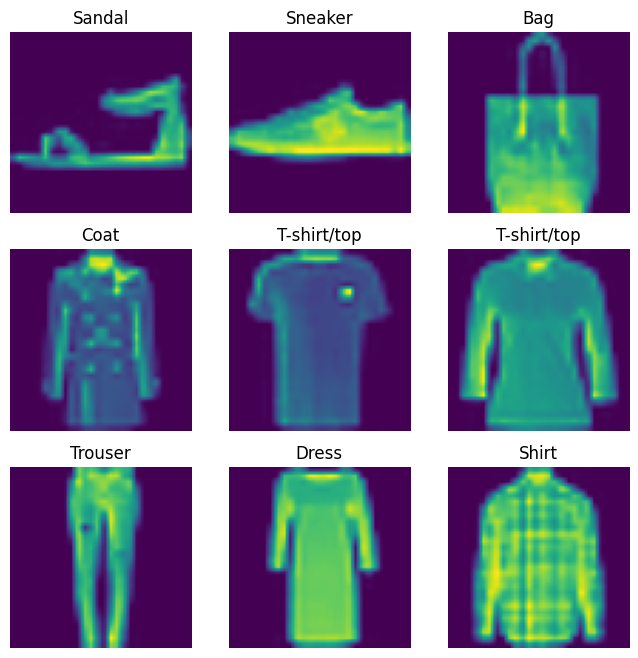

In [19]:
# randomly ploting image samples from the grayscale dataset
classes = train_dataset.classes
labels_map = {classes[i]:i for i in range(10)}  # getting class -> index map
labels_map = dict(map(reversed, labels_map.items()))  # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(8, 8))  # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size = (1,))  # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx.item()]  # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    if len(img.shape) == 3:
      plt.imshow(
          img.permute(1, 2, 0)
      )  # NOTE:- Color map is gray because we're converting imgae to grayscale / changing channel to HWC for color image
    else:
      plt.imshow(
          img, cmap="gray"
      )
    # sub plot code ends
plt.show()
# NOTE: WARRING BECAUSE OF auto_transforms

### Converting dataset to dataloader

In [20]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()//2  # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")

Numbers of Batches in Train Dataloader: 469
Numbers of Batches in Test Dataloader: 79


In [21]:
# class name
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [22]:
index_cls = train_dataset.class_to_idx
index_cls

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

## Models Training Utils Functions


### Plot loss curves of a model

In [23]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

### making training, testing steps, train model functions


In [24]:
# Training Step
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    profiler: torch.profiler.profile = None,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
      profiler (torch.profiler.profile, optional): Pytorch Profiler. Defaults to None.
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    if profiler != None:
      profiler.start()
      for step,(X, y) in enumerate(dataloader):  # loop in batches
        if step >= (1 + 1 + 3) * 2:
          break
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        
        train_acc += acc_fn(y_pred_logits, y).item()
        
        profiler.step()
      profiler.stop()
    else:
      for step,(X, y) in enumerate(dataloader):  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        
        train_acc += acc_fn(y_pred_logits, y).item()
    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)

# Testing Step
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)


# Training Function
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    save_info: str,
    profiler:torch.profiler.profile = None,
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
      save_info (str): info for saving model
      profiler (torch.profiler.profile, optional): Pytorch Profiler. Defaults to None.
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_acc = 0
    best_model_params = None

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
            profiler=profiler,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_params = model.state_dict()

    # 5. saving the best model
    torch.save(best_model_params, f"{model.__class__.__name__}_epoch_{epochs}_optim_adam_"+save_info+".pth")
    # 6. return result dict
    return result_dict

## Loss and accuracy Function

In [25]:
loss_fn = nn.CrossEntropyLoss()

acc_fn = Accuracy("multiclass",num_classes = len(class_names)).to(device)

## Build model

In [26]:
class CustomCNN(nn.Module):
    def __init__(self, trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_fc1):
        super().__init__()                                                     # Initialize parent class
        self.in_size = 32                                                                    # Input image size (28 pixels)
        self.kernel_size = 3                                                                 # Convolution filter size

        # # Define the convolutional layers
        # self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(3, 3), padding = 1, stride = 1)])  # List with the Conv layers
        # out_size = in_size - kernel_size + 1                                            # Size of the output kernel
        # out_size = int(out_size / 2)                                                    # Size after pooling
        # for i in range(1, num_conv_layers):
        #     self.convs.append(nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), padding = 1, stride = 1))
        #     out_size = out_size - kernel_size + 1                                       # Size of the output kernel
        #     out_size = int(out_size/2)                                                  # Size after pooling

        self.conv2_drop = nn.Dropout2d(p=drop_conv2)                                    # Dropout for conv2
        self.out_feature = num_filters * 64 * 64 # out_size         # Size of flattened features
        
        layers = []

        for i in range(num_conv_layers):
          if i == 0:
            layers.append(nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(3, 3), padding = 1, stride = 1))
            layers.append(nn.ReLU()) 

          else:
            if i%2 == 0:
              layers.append(nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), padding = 1, stride = 1))
              layers.append(nn.ReLU())
              layers.append(nn.MaxPool2d(kernel_size = (3,3), stride = 1, padding = 1))

            else:
              layers.append(nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), padding = 1, stride = 1))
              layers.append(nn.ReLU())

        self.cnn_layer = nn.Sequential(*layers)
        self.fc1 = nn.Sequential(
                                  nn.Flatten(),
                                  nn.Linear(self.out_feature, num_neurons),                            # Fully Connected layer 1
                                  nn.ReLU(),
                                  nn.Linear(num_neurons, 10)                                           # Fully Connected layer 2
                                )


    def forward(self, x):
        """
        Desc: Forward Pass.
        Parameters:
          x (torch.Tensor): Input tensor of size [N,1,28,28]
        Returns:
          X (torch.Tensor): The output tensor after forward propagation [N,10]
        # """
        x = self.cnn_layer(x)
        x = self.fc1(x)
        # x.view(-1, self.out_feature)                     # Flatten tensor
        return x
        # return F.log_softmax(x, dim=1)                       # log(softmax(x))

In [27]:
def objective(trial, n_trials=100):
  # Define range of values to be tested for the hyperparameters
  num_conv_layers = trial.suggest_int("num_conv_layers", 3, 6)  # Number of convolutional layers

  model = CustomCNN(trial, num_conv_layers, num_filters = 10, num_neurons = 512, drop_conv2 = 0.2,  drop_fc1 = 0.2).to(device)


  lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True) # Learning rates
  n_epochs = trial.suggest_int('n_estimators', 10, 50)
  optim = torch.optim.Adam(model.parameters(), lr = lr) # getattr(optim, optimizer_name)(model.parameters(), lr=lr)

  # Training of the model
  for epoch in range(n_epochs):
      train_loss, train_acc = training_step(
          dataloader=train_dataloader,
          acc_fn=acc_fn,
          device=device,
          loss_fn=loss_fn,
          model=model,
          optimizer=optim,
      )  # Train the model
      test_loss, test_acc = testing_step(
          dataloader=train_dataloader,
          acc_fn=acc_fn,
          device=device,
          loss_fn=loss_fn,
          model=model
      )
      # For pruning (stops trial early if not promising)
      trial.report(test_acc, epoch)
      # Handle pruning based on the intermediate value.
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

  return test_acc

In [ ]:
# Create an Optuna study to maximize test accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-05-02 02:20:32,013] A new study created in memory with name: no-name-bf4aa1e6-c7ac-486e-8f30-8c0f8f945822
[I 2023-05-02 02:51:55,891] Trial 0 finished with value: 0.10000777363713616 and parameters: {'num_conv_layers': 6, 'lr': 0.09454176848911686, 'n_estimators': 46}. Best is trial 0 with value: 0.10000777363713616.
[I 2023-05-02 03:06:23,235] Trial 1 finished with value: 0.9894500710308425 and parameters: {'num_conv_layers': 6, 'lr': 0.0001818444792094435, 'n_estimators': 21}. Best is trial 1 with value: 0.9894500710308425.
[I 2023-05-02 03:37:37,026] Trial 2 finished with value: 0.10004108918628205 and parameters: {'num_conv_layers': 5, 'lr': 0.02115237174808071, 'n_estimators': 48}. Best is trial 1 with value: 0.9894500710308425.
[I 2023-05-02 04:04:34,876] Trial 3 finished with value: 0.0999800106609808 and parameters: {'num_conv_layers': 5, 'lr': 0.05130813176629842, 'n_estimators': 41}. Best is trial 1 with value: 0.9894500710308425.
[I 2023-05-02 04:36:33,243] Trial 4 f

In [ ]:
# Find number of pruned and completed trials
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Display the study statistics
print("\nStudy statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

trial = study.best_trial
print("Best trial:")
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))